<h1>Salary Predictions Based on Job Descriptions</h1>

# Part 1 - DEFINE

### 1 : The problem

The job market is complex. HR must have a clear understanding of what an appropriate salary is for a new job posting and how various factors can affect the salary offered.

The goal of this project is to examine previous job postings with salaries and use this data to predict the salaries for new job postings.

Factors include:
- highest level of degree earned
- year of experience
- job title
- the industry the job is in
- how far from the nearest metropolis


__author__ = "Jennifer Ma"
__email__ = "jenniferfmma@gmail.com"

## Part 2 - DISCOVER



In [1]:
#import libraries used for data manipulation and visual representation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk

<h3>2 : Load the data</h3>

The data provided separates the salary information and the factors that may be influencing the offered salary in another.

In [2]:
#load the data into a Pandas dataframe
salary_df = pd.read_csv('data/train_salaries.csv')
salary_df.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [3]:
train_features_df = pd.read_csv('data/train_features.csv')
train_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [4]:
test_features_df = pd.read_csv('data/test_features.csv')
test_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


The training df and the test df both have the same features. Therefore, we can consider all of the features during training since we can also consider them for the test set to make the salary prediction.

<h3>3. Quality check of data</h3>

In [5]:
# Check the data types
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [6]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


<h4>Check data for duplicate values</h4>

In [8]:
salary_df.duplicated().sum()

0

In [9]:
train_features_df.duplicated().sum()

0

In [10]:
test_features_df.duplicated().sum()

0

Each provided data set contains 1 000 000 job postings with no duplicated rows.

<h4>Identify numeric and categorical variables</h4>

In [11]:
# Summarize each feature variable
features = list(train_features_df.columns)
print(features)

['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [12]:
train_features_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [13]:
train_features_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684802046,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [14]:
# Merge the two training set dataframes together.

training_df = pd.merge(train_features_df, salary_df, on='jobId')
training_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [15]:
# Delete the two original df to save memory
del salary_df
del train_features_df

In [16]:
# Display the statistical overview of the salary
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [17]:
# Check to see if there are any missing values
training_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


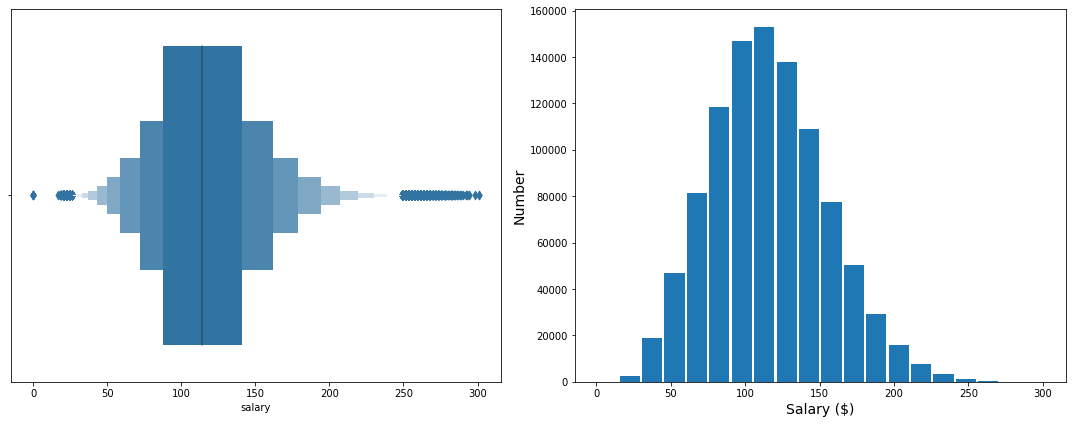

In [18]:
# Target Feature : Salary

# Graph
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxenplot(training_df['salary'])
plt.subplot(1,2,2)
hist_salary = plt.hist(training_df['salary'], rwidth = 0.9, bins= 20)
plt.xlabel("Salary ($)", size= 14)
plt.ylabel("Number", size= 14)
plt.tight_layout()
plt.show()

<h3>Identifying Outliers</h3>

In [19]:
from numpy import percentile

# Identify potential outliers using the IQR rule

# Calculate interquartile range
q25 = percentile(training_df['salary'], 25)
q75 = percentile(training_df['salary'], 75)
iqr = q75 - q25

# Calculate cut-off values
cut_off = iqr * 1.5
lower = q25 - cut_off
upper = q75 + cut_off

print('The upper and lower bounds for potential outliers are {} and {}.'.format(upper, lower))

The upper and lower bounds for potential outliers are 220.5 and 8.5.


<h3>Evaluating Potential Outliers</h3>

In [20]:
# Check potential lower outliers
training_df[training_df['salary'] < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


There are 5 jobs that have a salary of 0. These are not likely unpaid positions so these rows will be dropped.

In [21]:
training_df = training_df[training_df.salary > 8.5]
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [22]:
training_df.shape

(999995, 9)

In [23]:
# Check for potential upper outliers
training_df[training_df['salary'] > 220.5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7117 entries, 266 to 999893
Data columns (total 9 columns):
jobId                  7117 non-null object
companyId              7117 non-null object
jobType                7117 non-null object
degree                 7117 non-null object
major                  7117 non-null object
industry               7117 non-null object
yearsExperience        7117 non-null int64
milesFromMetropolis    7117 non-null int64
salary                 7117 non-null int64
dtypes: int64(3), object(6)
memory usage: 556.0+ KB


In [24]:
# Check how many values occur above upper outlier cut-off
training_df.loc[training_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [25]:
# It is least likely that a junior position would be paid such a high amount
# Check Junior jobs that also earn > $220.5K
training_df.loc[(training_df['salary'] > 220.5) & (training_df['jobType'] =='JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


Although Junior positions, all these jobs are mostly in finance or oil and are graduate degree holders and seem legitimate. Keep all of these.

### 4 : Explore the data (EDA)

In [26]:
num_cols = ['yearsExperience', 'milesFromMetropolis']
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']

In [27]:
# define function for numerical features

def plot_numFeat(df, col):
    '''Make 2 plots of numerical feature:
    left: distribution of samples
    right: dependence of salary on feature'''
    
    plt.figure(figsize=(12, 5))
        
    plt.subplot(1,2,1)
    df[col].value_counts().sort_index().plot()
    plt.ylabel('Counts')
    
    plt.subplot(1,2,2)
    # Calculate mean and standard deviation
    mean = df.groupby(col)['salary'].mean()
    std = df.groupby(col)['salary'].std()
    
    # Plot mean
    # Use fill_between to highlight the error
    mean.plot()
    plt.fill_between(range(len(std.index)), 
                 mean.values - std.values, 
                 mean.values + std.values, 
                 \
                alpha = 0.1)
    plt.ylabel('Salary')

Based on the above data exploration, the categorical features are actual labeled as data type 'object'. Change those to categorical data type.

In [28]:
# Show data types
training_df.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [29]:
for col in training_df.columns:
    if training_df[col].dtype.name == 'object':
        training_df[col] = training_df[col].astype('category')

training_df.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [30]:
# Define a function for categorical features

def plot_catFeat(df, col):
    '''Make 2 plots for categorical features:
    left: distribution of samples
    right: dependence of salary on feature
    '''
    plt.figure(figsize = (12, 5))
    
    plt.subplot(1,2,1)
    mean = df.groupby([col])['salary'].mean()
    ind = mean.sort_values().index
    
    df[col].value_counts().plot()
    plt.ylabel('Counts')
    plt.xticks(rotation = 45, horizontalalignment = 'right')
    
    plt.subplot(1,2,2)
    mean = df.groupby([col])['salary'].mean()
    ind = mean.sort_values().index
    
    sns.boxenplot(x= col, y = 'salary', data= df, order= ind)
    plt.xlabel(col)
    plt.ylabel('Salary ($)')
    plt.xticks(rotation = 45, horizontalalignment = 'right')

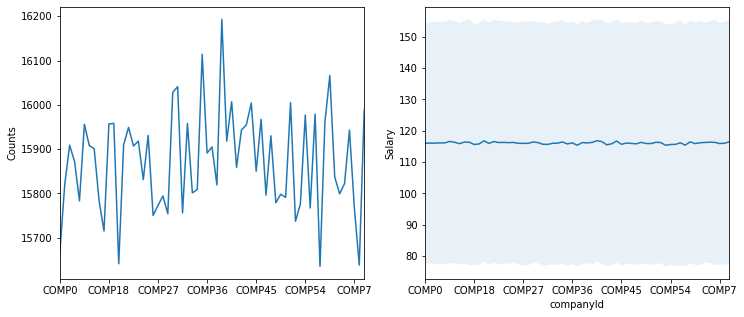

In [31]:
# jobID is a unique identifier and is not considered a feature
# Feature 1 = companyId

plot_numFeat(training_df, 'companyId')

The salary is not associated with the company.

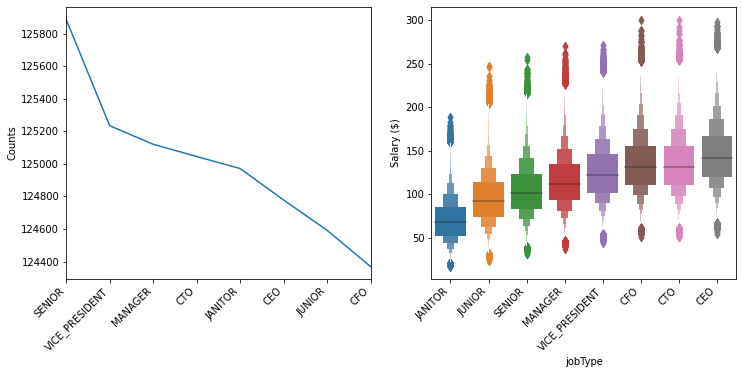

In [32]:
plot_catFeat(training_df, 'jobType')

There is a positive correlation between job type and salary.

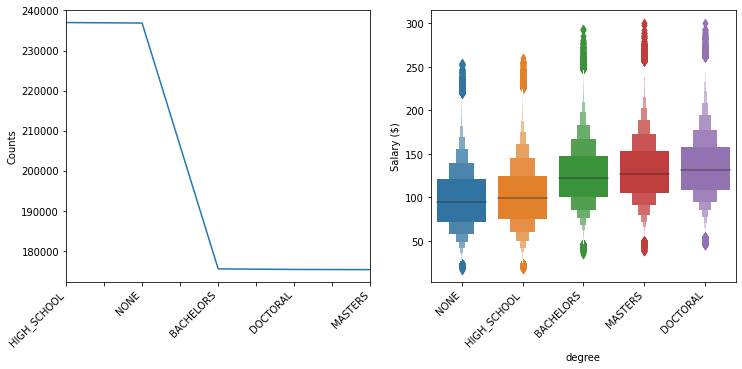

In [33]:
# Feature 3 : "degree"

plot_catFeat(training_df, 'degree')

Having a higher degree corresponds with an increase in the average salary.

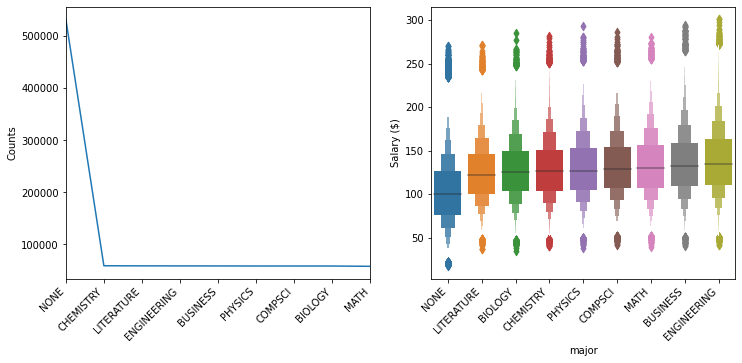

In [34]:
# Feature 4 : major

plot_catFeat(training_df, 'major')

The data shows that if a college major was picked, the college major that was chosen doesn't have a large impact on the salary. However, those with no college major have a lower mean salary, but still have the potential to earn over $200K per year. The data also indicates that over half of the data points indicate that no college major was chosen.

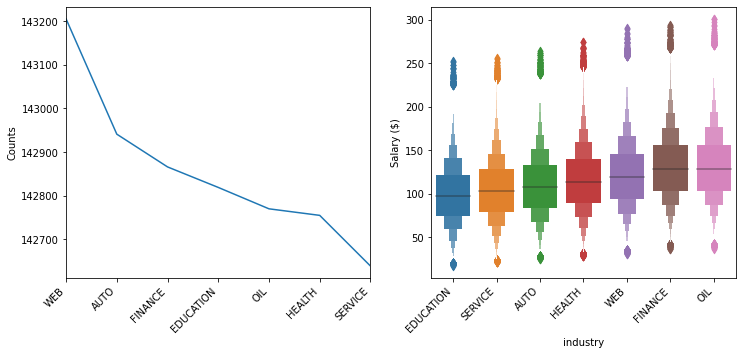

In [35]:
# Feature 5 : industry

plot_catFeat(training_df, 'industry')

The data shows that the oil and finance industries tend to pay the highest, while education and service tend to be the lowest.

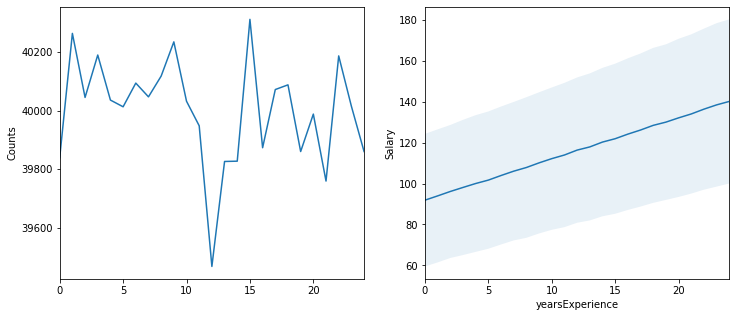

In [36]:
# Feature 6 = 'yearsExperience'

plot_numFeat(training_df, 'yearsExperience')

In general, there is a positive correlation between the salary and the number of years of experience.

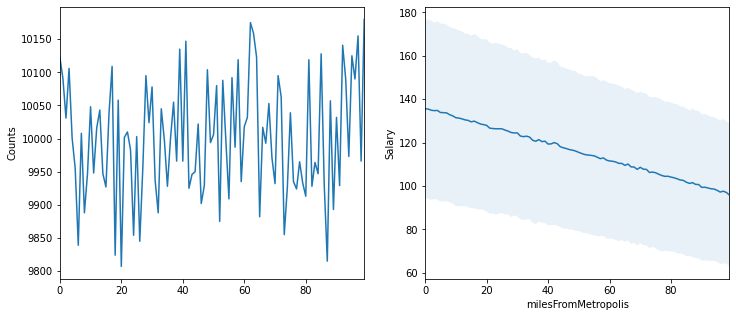

In [37]:
# Feature 7 = 'milesFromMetropolis'

plot_numFeat(training_df, 'milesFromMetropolis')

In general, the salary decreases with increasing distance to metropolis.

<h2>Correlation Matrix</h2>

In [38]:
# Show data types
df = training_df.copy()
df['jobId'] = df['jobId'].astype('object')
df.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [39]:
# Create a correlation matrix
# What features correlate most with salary? Are there any other correlations?

def encode_label(df, col):
    # encode the categories using average salary for each category to replace label
    category_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        category_dict[cat] = df[df[col] == cat]['salary'].mean()
    df[col] = df[col].map(category_dict)

In [40]:
# Encode labels in df
for col in df.columns:
    if df[col].dtype.name == "category":
        encode_label(df, col)

df.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [41]:
for col in cat_cols:
    df[col]=df[col].astype('int64')

df.dtypes

jobId                  object
companyId               int64
jobType                 int64
degree                  int64
major                   int64
industry                int64
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

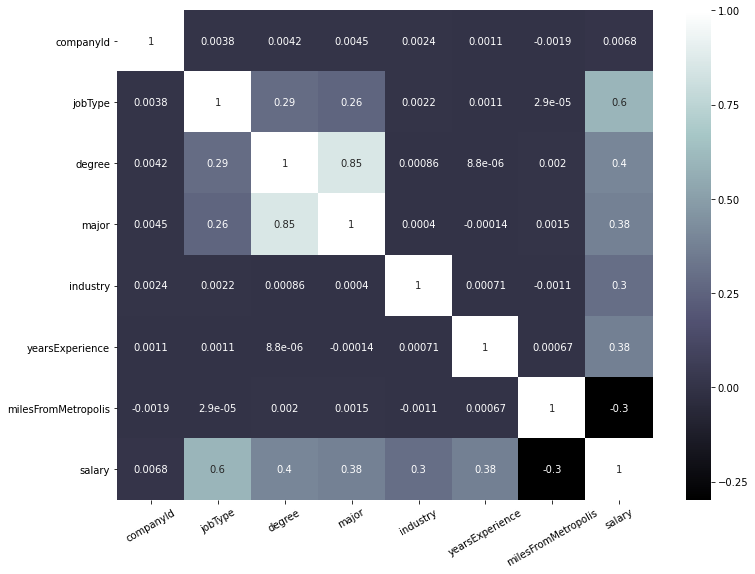

In [42]:
fig = plt.figure(figsize=(12, 9))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

sns.heatmap(df[features + ['salary']].corr(), 
            cmap='bone',
            annot=True)
plt.xticks(rotation=30)
plt.show()

<h3>EDA 2</h3>

Correlation between different features.

There is a wide distribution of salaries that can be achieved in all industries, all degree types, job types, and majors. Company ID doesn't seem to have an impact on salary and will be removed for future analysis.

Question: Considering this, is there certain industries where a higher education is a benefit in getting a higher paid job?

Question: Does having a higher education lead to having a job position that is also higher up, ultimately leading to a higher pay?

Question: How does the degree type and the number of years of experience affect the salary? After a person finishes school with a higher degree, they will generally have no industry experience, a feature that is positively correlated with salary.

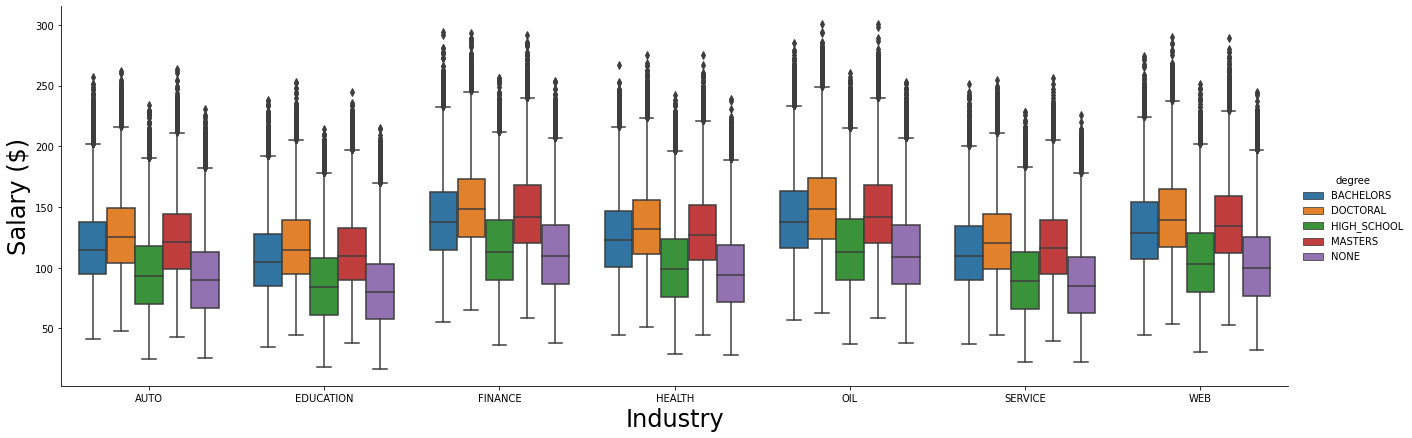

In [43]:
# Graph Salary vs Industry

sns.catplot(
    x = 'industry', 
    y = 'salary', 
    data = training_df.sort_values('degree'), 
    hue = 'degree', 
    kind="box",
    height = 6,
    aspect = 3)
plt.xlabel('Industry', fontsize = 24)
plt.ylabel('Salary ($)', fontsize = 24)
plt.show()

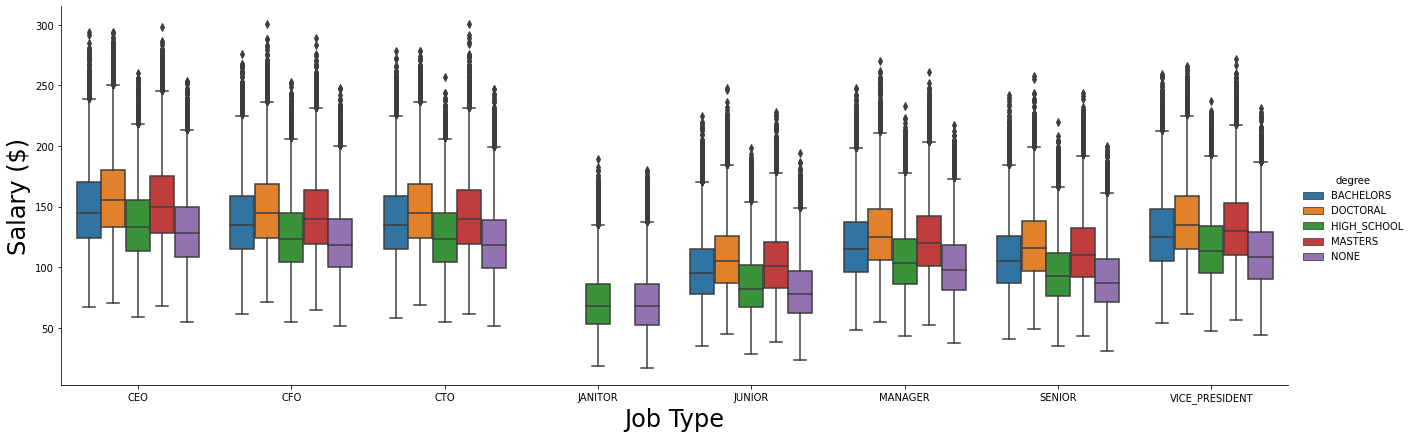

In [44]:
# Graph Salary vs degree

sns.catplot(
    x = 'jobType', 
    y = 'salary', 
    data = training_df.sort_values('degree'), 
    hue = 'degree', 
    kind="box",
    height = 6,
    aspect = 3)
plt.xlabel('Job Type', fontsize = 24)
plt.ylabel('Salary ($)', fontsize = 24)
plt.show()

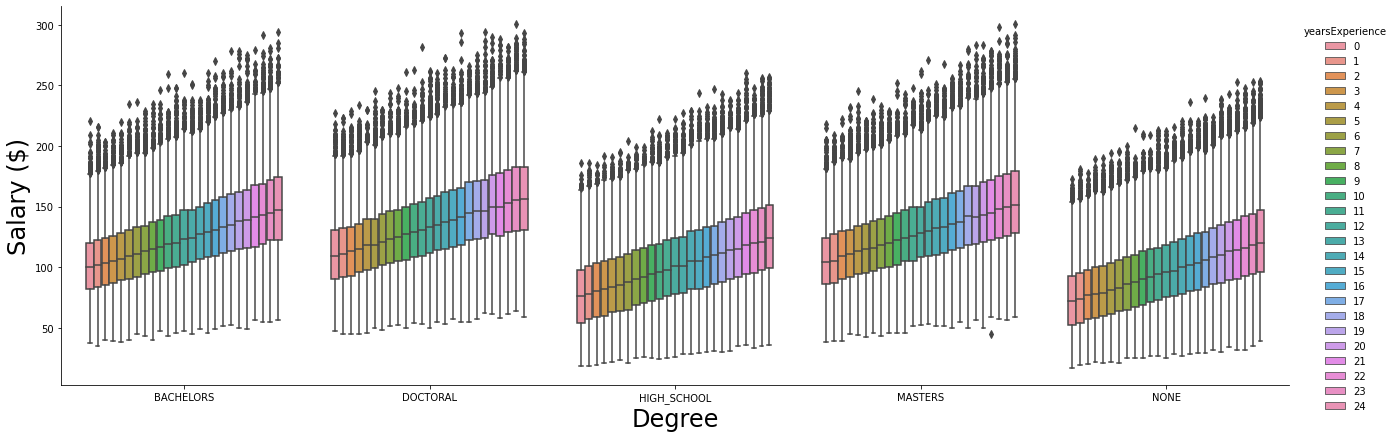

In [45]:
# Graph Salary vs degree and yearsExperience

sns.catplot(
    x = 'degree', 
    y = 'salary', 
    data = training_df.sort_values('yearsExperience'), 
    hue = 'yearsExperience', 
    kind="box",
    height = 6,
    aspect = 3)
plt.xlabel('Degree', fontsize = 24)
plt.ylabel('Salary ($)', fontsize = 24)
plt.show()

### 5 : Establish a baseline

#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import mean_squared_error

# Create a baseline model using a simple model: Linear Regression

X = df.drop(columns = ['jobId', 'companyId', 'salary'])
y = df['salary']
lin_reg = LinearRegression().fit(X, y)

# Measure the efficacy of baseline model using MSE
neg_mse = cross_val_score(lin_reg, X, y, scoring ='neg_mean_squared_error', cv = 5)
baseline_score = -1.0*np.mean(neg_mse)

print('Baseline model MSE: ', baseline_score)

Baseline model MSE:  399.76793197190153


### 6 : Hypothesize solution

<h4>Models:</h4>

In addition to Linear Regression, other algorithms that may also be suited to solving this problem are Random Forest Regression and Gradient Boost Regression.
<ul>
    <li>Random Forest Regression combines multiple models to create more powerful models (i.e. better accuracy).  The parameters can easily be adjusted to control model complexity.</li>
    <li>Gradient Boosted Regression is similar to Random Forest, but tends to be faster. It works by correcting previous trees' mistakes, improving accuracy.</li>
    <li>Linear Regression is a simple model, which is sometimes best. It can be better fit by adding interaction features and polynomial features if necessary.</li>
</ul>

The goal is to improve the prediction results over the baseline model shown above.

<h4>Feature Generation</h4>

EDA indicates that the job type, degree, and major features have the strongest positive relationship with salary offered. This suggests that additional features with these initial ones can contribute to model accuracy.

Save training_df to file

In [49]:
training_df.to_csv('data/training_df.csv', index=False)